In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler


In [2]:
df0 = pd.read_csv("train_clean.csv")

del df0["Unnamed: 0"]
del df0["cluster"]
### 將categorical columns轉成數字型態
df0.group = df0.group.astype("category").cat.codes
df0.unit = df0.unit.astype("category").cat.codes
df0.pharmForm = df0.pharmForm.astype("category").cat.codes
df0.campaignIndex = df0.campaignIndex.astype("category").cat.codes

print(df0.shape)
df0.head()

(2756003, 22)


,day,pid,click,basket,order,revenue,lineID,number,group,unit,...,adFlag,availability,competitorPrice,price,manufacturer,genericProduct,salesIndex,category,rrp,Content
0,1,6570,1,0,0,0.00,0,0.0,529,5,...,0.0,0.333333,0.055180,0.044533,0.238274,0.0,0.0,0.470588,0.044900,0.002261
1,1,14922,0,1,0,0.00,1,0.0,373,7,...,1.0,0.000000,0.032390,0.023045,0.015947,1.0,0.0,0.159314,0.046283,0.002261
2,1,16382,0,1,0,0.00,2,0.0,503,5,...,0.0,0.000000,0.055822,0.042342,0.037523,0.0,1.0,0.095588,0.045468,0.004534
3,1,1145,0,0,1,6.55,3,1.0,308,1,...,1.0,0.000000,0.024906,0.017238,0.047842,0.0,0.0,0.058824,0.022820,0.002716
4,1,3394,0,0,1,4.14,4,1.0,458,7,...,0.0,0.000000,0.016592,0.010876,0.083490,0.0,1.0,0.031863,0.019906,0.002261


In [3]:
def missing(df):
    print('Size of testing dataset : %d' % (df.shape[0]))
    df1 = df.dropna()
    print('Size of testing dataset DropNA : %d' % (df1.shape[0]))
    display(df.isnull().sum())

In [4]:
missing(df0)

Size of testing dataset : 2756003
Size of testing dataset DropNA : 2756003


day                0
pid                0
click              0
basket             0
order              0
revenue            0
lineID             0
number             0
group              0
unit               0
pharmForm          0
campaignIndex      0
adFlag             0
availability       0
competitorPrice    0
price              0
manufacturer       0
genericProduct     0
salesIndex         0
category           0
rrp                0
Content            0
dtype: int64

In [5]:
df = df0[df0.day <= 62]
hold = df0[df0.day > 62]
print("Number of training :", df.shape[0])
print("Number of hold :", hold.shape[0])

Number of training : 1782748
Number of hold : 973255


In [6]:
### X
X0 = np.array(df.drop(["number","order","click","basket","revenue"], axis=1))
sc = MinMaxScaler(feature_range=(0, 1), copy=True)
X = sc.fit_transform(X0)

### Y
Y = df[["number","order"]]
print(Y.order.value_counts())
from keras.utils import np_utils
y = np_utils.to_categorical(np.array(Y[["order"]]), 2) 

0    1313212
1     469536
Name: order, dtype: int64


Using TensorFlow backend.


In [7]:
X_train = X[0:1397455, :]
y_train = y[0:1397455, :]

X_test = X[1397455:1746818, :]
y_test = y[1397455:1746818, :]

In [8]:
def prepare_sequences(x_train, y_train, window_length):
    windows = []
    windows_y = []
    for i, sequence in enumerate(x_train):
        len_seq = len(sequence)
        for window_start in range(0, len_seq - window_length + 1):
            window_end = window_start + window_length
            window = sequence[window_start:window_end]
            windows.append(window)
            windows_y.append(y_train[i])
    return np.array(windows), np.array(windows_y)

In [14]:
X_train_new, y_train_new = prepare_sequences(X_train, y_train, 17)
X_train_new = X_train_new.reshape(X_train_new.shape[0], X_train_new.shape[1], 1)
print("Shape of sequence_X :", X_train_new.shape)
print("Shape of sequence_y :", y_train_new.shape)

Shape of sequence_X : (1397455, 17, 1)
Shape of sequence_y : (1397455, 2)


In [17]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

max_len = X_train_new.shape[1]
batch_size = 10000
nb_epoch = 2

print('Building STATELESS model...')
model = Sequential()
model.add(LSTM(16, input_shape=(max_len, 1), return_sequences = False, stateful = False))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])
model.summary()

Building STATELESS model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 16)                1152      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34        
Total params: 1,186
Trainable params: 1,186
Non-trainable params: 0
_________________________________________________________________


Train on 1257709 samples, validate on 139746 samples
Epoch 1/2
1257709/1257709 [==============================] - 97s - loss: 1.0250 - acc: 0.3277 - val_loss: 0.9252 - val_acc: 0.6218

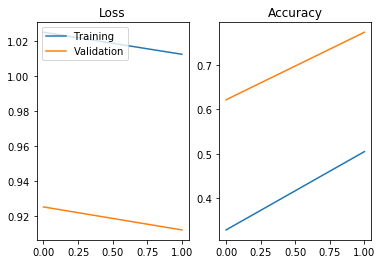

In [18]:
history = model.fit(X_train_new, y_train_new,
                    batch_size = batch_size,  
                    epochs = nb_epoch,  
                    verbose = 1,  
                    validation_split = 0.1,  
                    class_weight = {0: 1, 1: 2.7})

loss = history.history.get('loss')
acc = history.history.get('acc')

''' Access the performance on validation data '''
val_loss = history.history.get('val_loss')
val_acc = history.history.get('val_acc')

''' Visualize the loss and accuracy of both models'''
import matplotlib.pyplot as plt
plt.figure(0)
plt.subplot(121)
plt.plot(range(len(loss)), loss,label = 'Training')
plt.plot(range(len(val_loss)), val_loss,label = 'Validation')
plt.title('Loss')
plt.legend(loc='upper left')
plt.subplot(122)
plt.plot(range(len(acc)), acc,label = 'Training')
plt.plot(range(len(val_acc)), val_acc,label = 'Validation')
plt.title('Accuracy')
plt.show()

In [21]:
X_test_new, y_test_new = prepare_sequences(X_test, y_test, 17)
X_test_new = X_test_new.reshape(X_test_new.shape[0], X_test_new.shape[1], 1)
print("Shape of sequence_X :", X_test_new.shape)
print("Shape of sequence_y :", X_test_new.shape)

### Final evaluation of the model
scores = model.evaluate(X_test_new, y_test_new, verbose = 0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Shape of sequence_X : (349363, 17, 1)
Shape of sequence_y : (349363, 17, 1)
Accuracy: 77.76%


## regression

In [26]:
y = np.array(Y["number"]).reshape(Y.shape[0], 1)

X_train = X[0:1397455, :]
y_train = y[0:1397455, :]

X_test = X[1397455:1746818, :]
y_test = y[1397455:1746818, :]

In [36]:
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

nb_epoch = 2
batch_size = 10000
def baseline_model():
    model = Sequential()
    model.add(Dense(14, input_dim=X_train.shape[1], init='normal', activation='relu'))
    model.add(Dense(7, init='normal', activation='relu'))
    model.add(Dense(1, init='normal'))
    # Compile model
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    return model
clf = KerasRegressor(build_fn = baseline_model, nb_epoch = nb_epoch,
                     batch_size = batch_size, verbose = 0)

/Users/Shawn/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(14, input_dim=17, activation="relu", kernel_initializer="normal")`
/Users/Shawn/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(7, activation="relu", kernel_initializer="normal")`
/Users/Shawn/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="normal")`


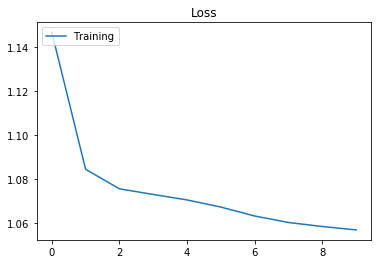

In [37]:
history = clf.fit(X_train, y_train)

loss = history.history.get('loss')
''' Visualize the loss and accuracy of both models'''
import matplotlib.pyplot as plt
plt.figure(0)
plt.subplot(111)
plt.plot(range(len(loss)), loss,label = 'Training')
#plt.plot(range(len(val_loss)), val_loss,label = 'Validation')
plt.title('Loss')
plt.legend(loc='upper left')
plt.show()

### cross validation
kfold = KFold(n_splits = 10, random_state = 100)  
results = cross_val_score(clf, X_train, y_train, cv = kfold)  
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))  

In [40]:
def testing_regression(model, X_test, y_test):
    pred = model.predict(X_test).reshape(y_test.shape[0], 1)  
    y_test = y_test.reshape(X_test.shape[0], 1)
    
    score = np.dot((pred - y_test).T, (pred - y_test))
    from sklearn.metrics import mean_squared_error
    score1 = mean_squared_error(y_test, pred, sample_weight = None, multioutput = 'uniform_average')
    print('===Euclidean_Distance===')
    print(score[0])
    print('===MSE===')
    print(score1)
    return pred

def plot_regression(test, pred):
    import matplotlib.pyplot as plt
    
    test = test.reshape(pred.shape[0],1)
    a = np.append(pred, test, axis=1)
    b = pd.DataFrame(a)
    b.columns = ["pred", "test"]  
    b.plot.scatter(x = 'test', y = 'pred', s = 50, alpha = 0.8)
    plt.title("scatter plot of pridiction and true")
    plt.show()

===Euclidean_Distance===
[ 278889.6079497]
===MSE===
0.79828032147


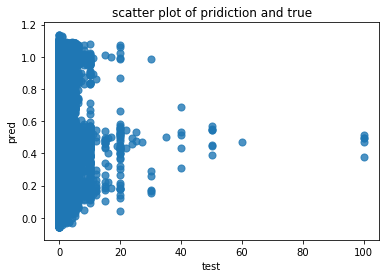

In [41]:
pre_rnn = testing_regression(clf, X_test, y_test)
plot_regression(y_test, pre_rnn)

In [42]:
from keras.models import Sequential  
from keras.layers.core import Dense, Activation  
from keras.layers.recurrent import LSTM

model_reg = Sequential()
model_reg.add(LSTM(16, input_shape=(max_len, 1), return_sequences = False, stateful = False))
model_reg.add(Dense(1, activation = 'linear'))
model_reg.compile(loss="mean_squared_error", optimizer="rmsprop")
model_reg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 16)                1152      
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 17        
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


/Users/Shawn/anaconda/lib/python3.6/site-packages/keras/models.py:837: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 1257709 samples, validate on 139746 samples
Epoch 1/2
1257709/1257709 [==============================] - 93s - loss: 1.1454 - val_loss: 0.6443

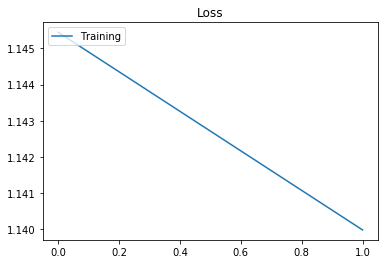

In [45]:
nb_epoch = 2
batch_size = 10000
history = model_reg.fit(X_train_new, y_train,
                        nb_epoch = nb_epoch,
                        batch_size = batch_size,
                        validation_split = 0.1)

loss = history.history.get('loss')
''' Visualize the loss and accuracy of both models'''
import matplotlib.pyplot as plt
plt.figure(0)
plt.subplot(111)
plt.plot(range(len(loss)), loss,label = 'Training')
#plt.plot(range(len(val_loss)), val_loss,label = 'Validation')
plt.title('Loss')
plt.legend(loc='upper left')
plt.show()

===Euclidean_Distance===
[ 289206.01711362]
===MSE===
0.827809519364


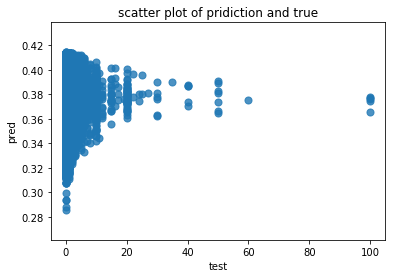

In [44]:
pre_rnn = testing_regression(model_reg, X_test_new, y_test)
plot_regression(y_test, pre_rnn)